## Compressed sensing with QFT

**Compressed sensing objective**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D}$ we want to find a vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } C\mathbf{x} = CF^{-1}\mathbf{s}
$$


**Tensorized extension of compressed sensing**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D\times\cdots\times D}$ represented in TT format with ranks $\{R_i\}_{i=1}^N$ we want to find a TT-vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } \mathcal{C}\mathcal{x} = \mathcal{C}\mathcal{F}^{-1}\mathcal{s}
$$

where $\mathcal{C}\,\&\,\mathcal{F}$ are Matrix Product Operators (MPO).


In [ ]:
# Install packages
!pip install quimb 

In [ ]:
import quimb as qu
import quimb.tensor as qtn

# Hyperparameters
num_cores, rank, physical_dim, num_steps = 8, 8, 2, 1000

# Randomly initialize the sparse tensor
s_mps = qtn.MPS_rand_state(L=num_cores, bond_dim=rank, tags=['S'])  # sparse tensor

# This will be the combined inverse fourier MPO + sampler MPO
w_mpo = qtn.MPO_rand_herm(L=num_cores, bond_dim=rank, tags=['HAM'])  

# Target we want to reconstruct
x_targ_mps = qtn.MPS_rand_state(L=num_cores, bond_dim=rank, tags=['X'])  # dense tensor

print("s")
print(s_mps.show())

print("\nw_mpo")
print(w_mpo.show())

s
 8 8 8 8 8 8 8 
●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │
None

w_mpo
│8│8│8│8│8│8│8│
●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │
None


/Users/marawangamal/Documents/github/ptn/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


In [ ]:
# Constrained optimization with L1
# from scipy.optimize import minimize

# # Define the objective function
# def loss_fn(s_mps, w_mpo, x_targ_mps, lam=1):
#     x_hat_mps = w_mpo.apply(other=s_mps)
#     diff = x_hat_mps - x_targ_mps
#     return diff.norm() + lam * s_mps.norm()

# loss_fn(s_mps, w_mpo, x_targ_mps)

# constraints = (
#     {"type": "eq", "fun": lambda s_mps_: w_mpo.apply(other=s_mps_) - x_targ_mps},
# )
# res = minimize(loss_fn, s_mps, constraints=constraints)

In [33]:
# Define the objective function
def loss_fn(s_mps, w_mpo, x_targ_mps, lam=1):
    x_hat_mps = w_mpo.apply(other=s_mps)
    diff = x_hat_mps - x_targ_mps
    return diff.norm() + lam * s_mps.norm()


# Define the optimizer
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    s_mps,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    # norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    loss_constants={"w_mpo": w_mpo, "x_targ_mps": x_targ_mps},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    # which gradient computation backend to use
    autodiff_backend="torch",
)

In [ ]:
# Optimize the tensor network
s_mps_opt = tnopt.optimize(num_steps)

# Print loss
print(f"Initial loss: {loss_fn(s_mps, w_mpo, x_targ_mps)}")
print(f"Final loss: {loss_fn(s_mps_opt, w_mpo, x_targ_mps)}")

  0%|          | 0/1000 [00:00<?, ?it/s]

+1.000363682768 [best: +1.000359814891] : : 1001it [00:04, 213.63it/s]                        


Initial loss: 2.00333825261809
Final loss: 1.0003636827681783


In [50]:
import numpy as np

def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append({
            'indices': cfg.tolist(),
            'amplitude': amp
        })

    return results


# example usage
samples_l1 = random_samples_with_amplitudes(s_mps_opt, num_samples=10000)


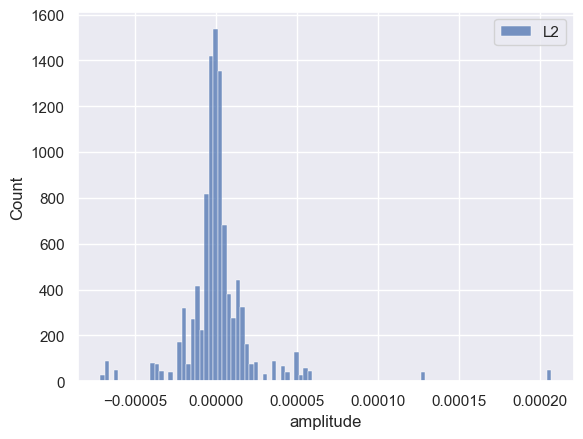

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(samples_l1)

sns.set_theme()

sns.histplot(df["amplitude"], bins=100, label="L2")
plt.legend()
plt.show()